In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(0)
import random
import json
import pandas as pd
from datetime import datetime, timedelta

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


In [2]:
df = pd.read_csv('C:/Users/Win11/Downloads/20240509_030938_45245_4dsx5.csv')
df_2 = pd.read_csv('C:/Users/Win11/Downloads/20240509_051907_83264_4dsx5.csv')
df = pd.concat([df, df_2], ignore_index = True)
df = df[df['matuirity_day'] > 0]

print(df.shape)
df.head(4)


(157617, 56)


,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,win_amount_last_14d,win_amount_last_7d,win_money_rate_sequence,max_bet,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18
0,10207496,2024-01-02 00:33:46.000,2,2,0.0,3,3.0,2,2,2,...,16.39,16.39,"[0.57,null,null]",1.00,0,0,0.0,0.0,0.0,0.0
1,10207496,2024-01-02 00:33:46.000,6,6,0.0,3,3.0,6,2,2,...,16.39,16.39,"[0.57,null,null,null,null,null,null]",1.00,0,0,0.0,0.0,0.0,0.0
2,10207496,2024-01-02 00:33:46.000,20,20,0.0,3,3.0,20,2,0,...,NaN,NaN,"[0.57,null,null,null,null,null,null,null,null,...",1.00,0,0,0.0,0.0,0.0,0.0
3,10208626,2024-01-02 03:05:04.000,2,2,0.0,4,4.0,2,3,3,...,35.07,35.07,"[0.49,null,null]",0.75,0,0,0.0,533.0,0.0,136.0


In [3]:
# REMOVE FEATURES AND DUMMIFY SEQUENCES 


def data_processing(df): 

    df['max_payment']           = df['max_payment']     / df['spent_to_date']
    df['max_daily_spent']       = df['max_daily_spent'] / df['spent_to_date']
    df['day_1_count_payment']   = (df['daily_payment_history_count'].apply(lambda x: x.replace('[', '').replace(']', '').split(',')[0])).astype(float)
    df['day_1_total_payment']   = (df['daily_spent_history_count'].apply(lambda x: x.replace('[', '').replace(']', '').split(',')[0])).astype(float)
    # df['d2_3_total_payment']    = (df['daily_spent_history_count'].apply(lambda x: x.replace('[', '').split(',')[1] + x.replace('[', '').split(',')[2])).astype(float)

    df['max_games_daily_games'] = df['max_games_daily_games'] / df['games_to_date']
    df['daily_games_first_1d']  = df['daily_games_first_1d']  / df['games_to_date']

    df['games_to_date']         = df['local_time_before_6'] + df['local_time_6_to_12'] + df['local_time_12_to_18'] + df['local_time_after_18'] 
    df['local_time_before_6']   = df['local_time_before_6'] / df['games_to_date']
    df['local_time_6_to_12']    = df['local_time_6_to_12']  / df['games_to_date']
    df['local_time_12_to_18']   = df['local_time_12_to_18'] / df['games_to_date']
    df['local_time_after_18']   = df['local_time_after_18'] / df['games_to_date']
    
    df['win_spent_ratio']       = df['win_amount_to_date']  / (df['spent_to_date']+0.0001)
    
    # Retention 
    df['full_[retention]']      = df['retention_sequence'].apply(lambda x: x[-2])
    df['full_pay_[retention]']  = df['daily_payment_history_binary'].apply(lambda x: x[-2])

    return df 

df = data_processing(df)

# Base Cols
cols = [
        # 'paying_matuirity', 'spent_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent'
        'paying_matuirity', 'spent_to_date','max_daily_spent'
        
        # , 'max_payment', 'payments_last_14d', 'payments_last_7d',  'payments_to_date',  'minutes_to_payment', 'minutes_to_pay_since_first_game'
        , 'max_payment', 'payments_to_date',  'minutes_to_payment', 'minutes_to_pay_since_first_game'
        
        # , 'games_last_14d', 'games_last_7d', 'games_to_date', 'max_games_daily_games', 'daily_games_first_14d', 'daily_games_first_7d', 'daily_games_first_1d', 'minutes_to_play'
        , 'games_to_date', 'max_games_daily_games', 'daily_games_first_1d', 'minutes_to_play'
        
        # , 'money_games_to_date', 'bet_money_to_date', 'max_bet',  'money_games_last_14d', 'money_games_last_7d'
        , 'money_games_to_date', 'bet_money_to_date', 'max_bet'

        # , 'win_amount_to_date',  'win_amount_last_14d', 'win_amount_last_7d'
        , 'win_amount_to_date'
        
        , 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date'
        
        , 'local_time_before_6', 'local_time_6_to_12', 'local_time_12_to_18', 'local_time_after_18'
        , 'full_pay_[retention]', 'full_[retention]', 'day_1_count_payment', 'win_spent_ratio'
        ]

# , 'days_30_usd_bet_money_sequence', 'days_100_usd_bet_money_sequence', 
columns_of_interest = ['retention_sequence', 'days_betting_money_sequence', 'days_50_usd_bet_money_sequence', 'daily_payment_history_binary']  # Add additional columns here if needed
# def truncate_list(lst):
#     return lst[-14:]
# for column in columns_of_interest:
#     df[column] = df[column].apply(truncate_list)

# II. Execute the dummification
columns_info = {'retention_sequence': 'playing_days_'
                # , 'money_bet_sequence': 'money_bet_'
                , 'daily_payment_history_binary': 'payer_'
                # , 'daily_payment_history_count': 'pay_'
                , 'days_betting_money_sequence': 'days_bet_'
                , 'days_50_usd_bet_money_sequence': 'days_gt50_bet_'
                # , 'province': 'province_'
                }  # Add additional columns and identifiers here if needed

dummy_variable_list = []  # List to store dummy variables generated for each column

for column, identifier in columns_info.items():
    # Calculate sum of 'new_disputer_30d' for each unique value in the column
    sum_disputer = df.groupby(column)['new_disputer_30d'].sum()
    # Filter unique values where sum is >= 12
    valid_values = sum_disputer[sum_disputer >= 15].index.tolist()
    # Generate dummy variables for valid values
    dummy_variables = pd.get_dummies(df[column].loc[df[column].isin(valid_values)], prefix=identifier).astype(int)
    dummy_variable_list.append(dummy_variables)
    df = pd.concat([df, dummy_variables], axis=1)

# Concatenate all dummy variables into a single DataFrame
final_dummy_variables = pd.concat(dummy_variable_list, axis=1)
cols = cols + list(final_dummy_variables.columns)

# III. Can remove extra items
items_to_remove = ['working_hours_bets_to_date', 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date', 'province']
cols = [item for item in cols if item not in items_to_remove]
final_dummy_variables.columns


Index(['playing_days__[1,0,0,0,0,0,0]', 'playing_days__[1,0,0]',
       'playing_days__[1,0,1]', 'playing_days__[1,0]', 'playing_days__[1,1,0]',
       'playing_days__[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]',
       'playing_days__[1,1,1,1,1,1,1]', 'playing_days__[1,1,1]',
       'playing_days__[1,1]', 'payer__[0,1]',
       'payer__[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]',
       'payer__[1,0,0,0,0,0,0]', 'payer__[1,0,0]', 'payer__[1,0,1]',
       'payer__[1,0]', 'payer__[1,1,0]', 'payer__[1,1,1,1,1,1,1]',
       'payer__[1,1,1]', 'payer__[1,1]', 'days_bet__[1,0,0,0,0,0,0]',
       'days_bet__[1,0,0]', 'days_bet__[1,0,1]', 'days_bet__[1,0]',
       'days_bet__[1,1,0]', 'days_bet__[1,1,1,1,1,1,1]', 'days_bet__[1,1,1]',
       'days_bet__[1,1]',
       'days_gt50_bet__[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]',
       'days_gt50_bet__[0,0,0,0,0,0,0]', 'days_gt50_bet__[0,0,0]',
       'days_gt50_bet__[0,0]', 'days_gt50_bet__[0,1]',
       'days_gt50_bet__[1,0,0,0,0,0,0]', 'days

In [5]:
df = df[df['day_1_total_payment'] < 500]


In [6]:
# TRAIN THE SYSTEM 

# You can try to include matuirity as a penalty and see what approach works better 
from sklearn.tree import _tree
import pandas as pd
from tqdm import tqdm

# Define the model 
def create_model(criterion, depth, leaf_size):

    pipe = Pipeline([
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe

def traverse_tree(tree, node_id = 0, depth = 0, dataset = None, path = None):

    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Disputer rate"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right) 
        # print('function here is okay')    
    
    else:
        leaf_size = np.sum(tree.value[node_id])
        # print('leaf_size', leaf_size)
        # print('else here is okay')
        # print(len(tree.value[node_id][0]))
        if len(tree.value[node_id][0]) > 1: 
            true_cases = tree.value[node_id][0][1]
        else: 
            true_cases = 0
        # print('else here is okay oh oh')
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        # print('有问题')
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Disputer rate": [proportion_true],
                                                    "Payers": [leaf_size], "Disputers": [true_cases]})], ignore_index=True)

    return dataset
    
high_level_dt = pd.DataFrame(columns = ["segments", "Event", "Disputer rate", "Payers", "Disputers"])  # Initiate an empty DataFrame to hold all datasets
model_results = []
all_model_results = []
criterion = 'log_loss'
depth = 7
leaf_size = 100
payment_cols = cols + ['new_disputer_30d']
segments = [1]
df['segments'] = 'User'
# Loop through segments

for segment in tqdm(df['segments'].unique()):
# for segment in ['maturity_day < 14 & payments > 1']:

    # Get fraction of everything_df based on segment
    result = df[df['segments'] == segment].fillna(0)
    payment_cols = cols + list(final_dummy_variables.columns) + ['new_disputer_30d']
    
    # Loop through matuirity days
    for maturity in result['matuirity_day'].unique(): 
    # for maturity in [1]: 

        # print(maturity)
        # Generate the Tree dataset and concatenate 
        train_data = result[result['matuirity_day'] == maturity][payment_cols]
        # print(train_data.shape[0])
        X_train, y_train = train_data.drop(columns = ['new_disputer_30d']), train_data['new_disputer_30d'] 
        # Train 
        clf = create_model(criterion, depth, leaf_size)

        clf.fit(X_train[cols], y_train)
        # print('meiyouyijian')
        # print('ok2')
        # Save the model into dictionary (Response, day, mo...)
        model_result = pd.DataFrame({
            'Matuirity': [maturity],
            'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)],
            'Model': [clf]
        })
        # print('命运')

        # Generate the dataset structure
        tree = clf[0].tree_
        # print(tree)
        # print('意见0')
        dataset = traverse_tree(tree)

        # try: 
        #     dataset = traverse_tree(tree)
        # except: 
        #     print('ojo')
        # print('意见1')
        event_columns = dataset['Event'].str.split(' & ', expand = True)
        # print('意见2')
        dataset = pd.concat([dataset, event_columns], axis = 1)
        dataset.insert(0, "Matuirity", maturity + 1)
        dataset.insert(0, "Segment", segment)
        high_level_dt = pd.concat([high_level_dt, dataset], ignore_index = True)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


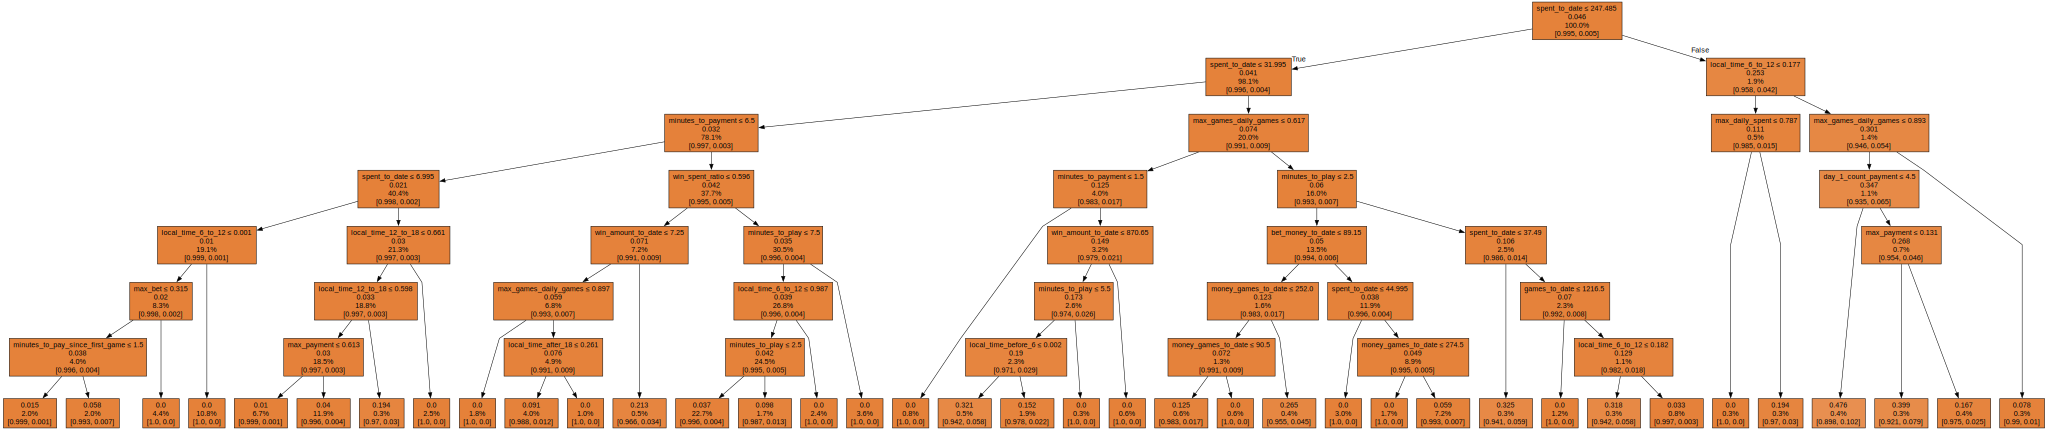

In [7]:
# SHOW ME ONE OF THE TREES

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz


# Create the decision tree classifier
# clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 6 - 200']['Model'].values[0][0]
clf = model_result['Model'].values[0][0]


# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = X_train.columns
                           # ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)
# print(dot_data)



In [8]:
# CLEAN AND SHOW THE TABLE

high_level_dt.rename(columns={i: f"Condition {i + 1}" for i in range(7)}, inplace=True)
high_level_dt = high_level_dt[['Segment', 'Matuirity', 'Condition 1', 'Condition 2', 'Condition 3', 'Condition 4', 'Condition 5', 'Condition 6', 'Condition 7', 'Disputer rate', 'Payers', 'Disputers']].sort_values(by=['Matuirity', 'Disputer rate'], ascending=False).reset_index(drop = True)
# high_level_dt = high_level_dt[['Segment', 'Matuirity', 'Condition 1', 'Condition 2', 'Condition 3', 'Condition 4', 'Condition 5'
#                                , 'Condition 6', 'Condition 7', 'Condition 8', 'Condition 9', 'Condition 10'
#                                , 'Disputer rate', 'Payers', 'Disputers']].sort_values(by='Disputer rate', ascending=False).reset_index(drop = True)

# high_level_dt.sort_values(by = ['Matuirity', 'Disputer rate'])
high_level_dt.head(6)
# high_level_dt[high_level_dt['Matuirity'] <= 7].head(700)


,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Condition 6,Condition 7,Disputer rate,Payers,Disputers
0,User,21.0,payments_to_date > 31.5,spent_to_date > 3035.495,local_time_before_6 ≤ 0.256,None,None,None,None,0.147059,136.0,20.0
1,User,21.0,payments_to_date > 31.5,spent_to_date ≤ 3035.495,max_daily_spent > 0.355,minutes_to_payment > 23.5,None,None,None,0.135922,103.0,14.0
2,User,21.0,payments_to_date > 31.5,spent_to_date ≤ 3035.495,max_daily_spent ≤ 0.355,payments_to_date > 37.5,spent_to_date ≤ 283.5,None,None,0.072727,110.0,8.0
3,User,21.0,payments_to_date ≤ 31.5,payments_to_date > 6.5,max_games_daily_games ≤ 0.205,local_time_before_6 > 0.196,local_time_12_to_18 > 0.06,win_spent_ratio ≤ 4.302,None,0.060606,165.0,10.0
4,User,21.0,payments_to_date ≤ 31.5,payments_to_date ≤ 6.5,spent_to_date > 9.995,local_time_12_to_18 > 0.556,max_daily_spent > 0.945,spent_to_date > 36.0,local_time_12_to_18 ≤ 0.772,0.050000,100.0,5.0
5,User,21.0,payments_to_date ≤ 31.5,payments_to_date > 6.5,max_games_daily_games > 0.205,minutes_to_pay_since_first_game > 1940.0,games_to_date > 3168.0,local_time_12_to_18 > 0.08,local_time_12_to_18 ≤ 0.279,0.041096,219.0,9.0


In [9]:
del high_level_dt['Segment']
top_3_values = high_level_dt.groupby('Matuirity').apply(lambda x: x.nlargest(3, 'Disputer rate')).reset_index(drop=True)
top_3_values

,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Condition 6,Condition 7,Disputer rate,Payers,Disputers
0,2.0,spent_to_date > 247.485,local_time_6_to_12 > 0.177,max_games_daily_games ≤ 0.893,day_1_count_payment ≤ 4.5,None,None,None,0.102190,137.0,14.0
1,2.0,spent_to_date > 247.485,local_time_6_to_12 > 0.177,max_games_daily_games ≤ 0.893,day_1_count_payment > 4.5,max_payment ≤ 0.131,None,None,0.079208,101.0,8.0
2,2.0,spent_to_date ≤ 247.485,spent_to_date > 31.995,max_games_daily_games > 0.617,minutes_to_play > 2.5,spent_to_date ≤ 37.49,None,None,0.059406,101.0,6.0
3,3.0,spent_to_date > 70.99,spent_to_date > 604.495,local_time_before_6 ≤ 0.188,None,None,None,None,0.110000,100.0,11.0
4,3.0,spent_to_date > 70.99,spent_to_date ≤ 604.495,games_to_date > 2790.5,money_games_to_date ≤ 2093.5,max_payment ≤ 0.308,minutes_to_pay_since_first_game > 2.5,None,0.078534,191.0,15.0
5,3.0,spent_to_date > 70.99,spent_to_date ≤ 604.495,games_to_date ≤ 2790.5,win_amount_to_date ≤ 167.755,max_payment > 0.262,local_time_after_18 > 0.042,None,0.060241,166.0,10.0
6,7.0,payments_to_date > 11.5,spent_to_date > 806.5,day_1_count_payment ≤ 2.5,None,None,None,None,0.133929,112.0,15.0
7,7.0,payments_to_date > 11.5,spent_to_date ≤ 806.5,minutes_to_pay_since_first_game > 7.5,max_daily_spent > 0.349,games_to_date > 4767.5,win_amount_to_date ≤ 796.84,None,0.086957,115.0,10.0
8,7.0,payments_to_date ≤ 11.5,max_games_daily_games ≤ 0.511,max_payment ≤ 0.608,max_daily_spent > 0.75,games_to_date ≤ 4234.5,money_games_to_date > 192.0,win_amount_to_date ≤ 51.16,0.077586,116.0,9.0
9,21.0,payments_to_date > 31.5,spent_to_date > 3035.495,local_time_before_6 ≤ 0.256,None,None,None,None,0.147059,136.0,20.0
